### Imports

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys
import torch
sys.path.append('..')
from src.dataset import ISICDataset
from definitions import ISIC_DIR
from src.segmentation import Segmenter,SegmenterConfig
from src.feature_extraction import FeatureExtractionConfig
from src.utils import display_segmentation_results
from PIL import Image

### Dataset Loading

In [2]:
dataset = ISICDataset(ISIC_DIR)

- Without artifact

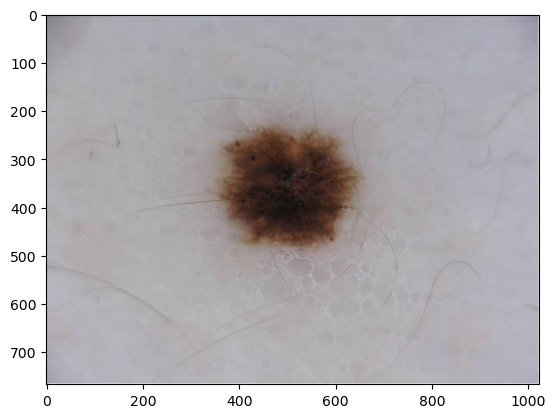

In [3]:
sample0 = dataset[1]
plt.imshow(sample0['image'])

- With artifacts

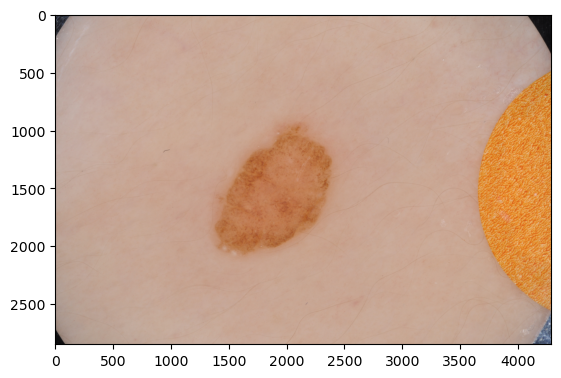

In [4]:
sample1 = dataset[481]
plt.imshow(sample1['image'])

### Artifacts detection

In [5]:
def get_mask(image : np.ndarray):
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Get binary mask
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Countour detection
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Get the largest contour
    c = max(contours, key = cv2.contourArea)

    # Create a mask with the largest contour
    mask = np.zeros_like(mask)
    cv2.drawContours(mask, [c], -1, 255, -1)

    return mask

In [6]:
def visualize(image : np.ndarray, mask : np.ndarray):
    
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))

    object_ = image * mask[:, :, None].astype(bool)

    ax[0].imshow(image)
    ax[0].set_title('Image')

    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title('Mask')

    ax[2].imshow(object_)
    ax[2].set_title('Object')

    plt.tight_layout()


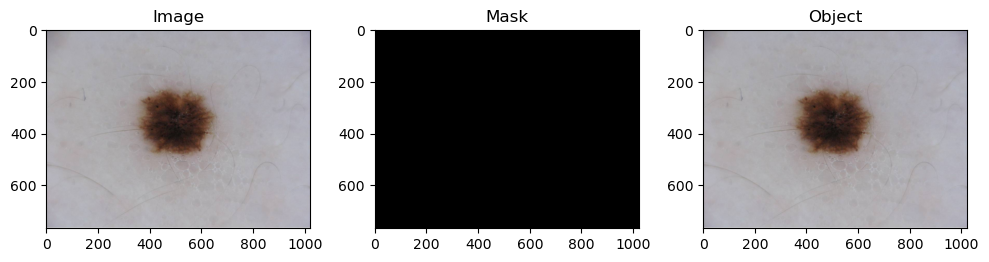

In [7]:
mask = get_mask(np.array(sample0['image']))
visualize(np.array(sample0['image']), mask)

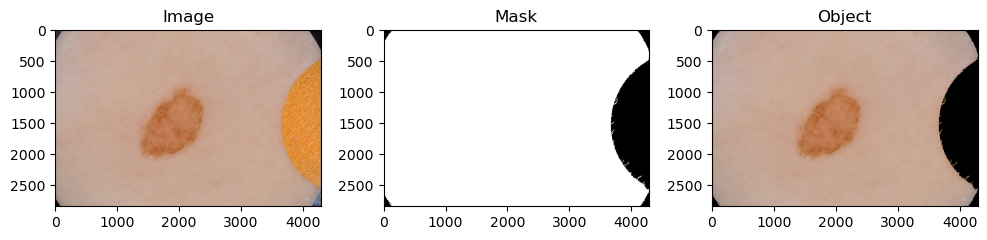

In [8]:
mask = get_mask(np.array(sample1['image']))
visualize(np.array(sample1['image']), mask)

### Segmentation

In [9]:
config = SegmenterConfig(
    segmentation_type="ncut",
    alpha=5.0,
    feature_extractor_config=FeatureExtractionConfig(
        model_name="facebook/dino-vits8",
        device="cuda",
        feature_type="key",
    ),
    activation="silu",
    num_layers=1,
    conv_type="arma",
    hidden_dim=32,
    num_clusters=2,
    device="cuda",
    threshold=0.6
)

In [10]:
segmenter = Segmenter(config)

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits8 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


- Without artifact removal

In [11]:
result = segmenter.segment(sample1['image'], lr=0.001, n_iters=20, show_progress=True)
display_segmentation_results(sample1, result['mask'].astype(bool).astype(int))

Optimizing:   0%|          | 0/20 [00:00<?, ?it/s]

ValueError: dimension mismatch

- With Artifact removal

In [12]:
mask = get_mask(np.array(sample1['image']))
ignore = torch.tensor(cv2.resize(mask, (224, 224)), dtype=torch.float32)
ignore = ignore.unfold(0, 8, 8).unfold(1, 8, 8).reshape(-1, 8 ** 2).mean(-1)
ignore = ignore == 255
print(ignore.float().mean())

tensor(0.8916)


Optimizing:   0%|          | 0/20 [00:00<?, ?it/s]

IoU: 0.000


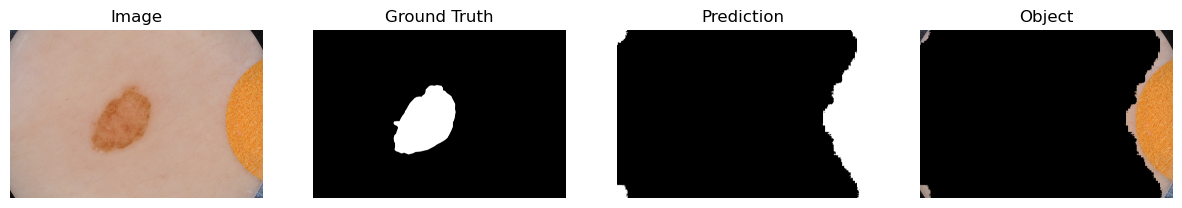

In [13]:
result = segmenter.segment(sample1['image'], lr=0.001, n_iters=20, show_progress=True, ignore=ignore)
display_segmentation_results(sample1, result['mask'].astype(bool).astype(int))

### Hair

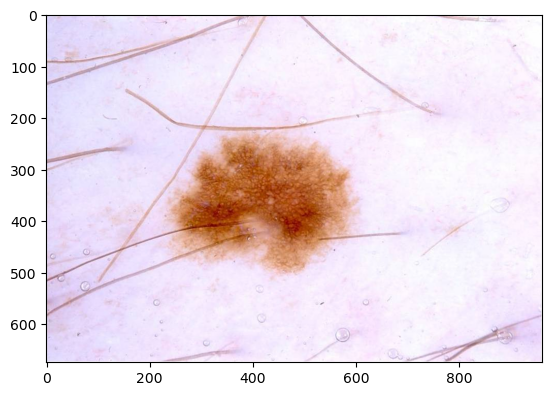

In [115]:
sample = dataset[148]
plt.imshow(sample['image'])

In [116]:
def remove_hair(image : np.ndarray) -> np.ndarray:

    #Gray scale
    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    #Black hat filter
    kernel = cv2.getStructuringElement(1,(9,9)) 
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)

    #Gaussian filter
    bhg= cv2.GaussianBlur(blackhat,(3,3),cv2.BORDER_DEFAULT)

    #Binary thresholding (MASK)
    ret,mask = cv2.threshold(bhg,10,255,cv2.THRESH_BINARY)

    #Replace pixels of the mask
    dst = cv2.inpaint(image,mask,6,cv2.INPAINT_TELEA)  

    return dst

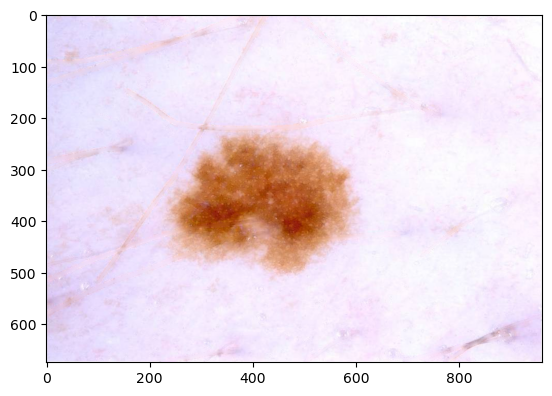

In [117]:
hair_removed = remove_hair(np.array(sample['image']))
plt.imshow(hair_removed)

- With hair

Optimizing:   0%|          | 0/50 [00:00<?, ?it/s]

IoU: 0.004


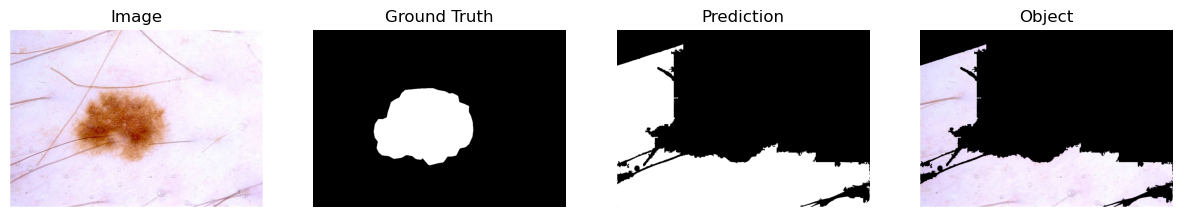

In [123]:
result = segmenter.segment(sample['image'], lr=0.001, n_iters=50, show_progress=True, ignore=ignore)
display_segmentation_results(sample, result['mask'].astype(bool).astype(int))

- Without hair

Optimizing:   0%|          | 0/50 [00:00<?, ?it/s]

IoU: 0.765


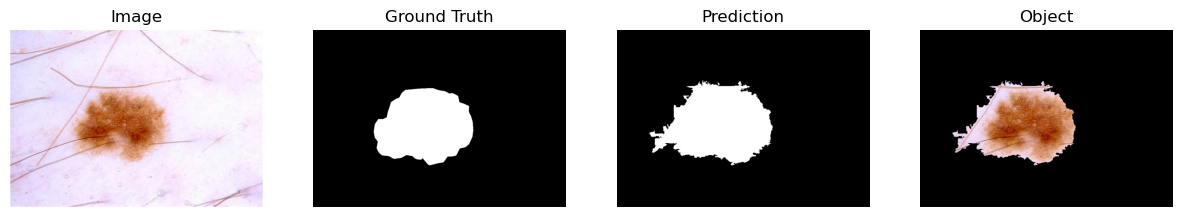

In [134]:
result = segmenter.segment(Image.fromarray(hair_removed), lr=0.001, n_iters=50, show_progress=True, ignore=ignore)
display_segmentation_results(sample, result['mask'].astype(bool).astype(int))

In [141]:
def flip_mask(
    image : np.ndarray,
    mask : np.ndarray,
) -> np.ndarray:
    
    mask = mask.astype(bool)

    background_pos = np.argwhere(~mask)
    object_pos = np.argwhere(mask)

    background_var = np.std(background_pos, axis=0)
    object_var = np.std(object_pos, axis=0)

    if object_var[0] > background_var[0] and object_var[1] > background_var[1]:
        mask = ~mask

    print(background_var, object_var)
    
    return mask

[207.97715841 294.21609634] [ 74.41021772 106.30205879]


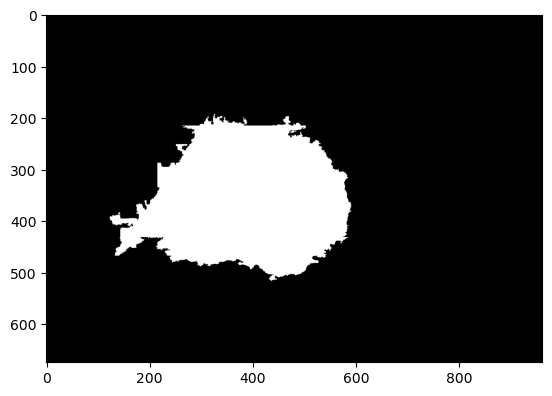

In [143]:
mask = flip_mask(
    image=np.array(sample['image']),
    mask=np.array(result['mask']).astype(bool),
)

plt.imshow(mask, cmap='gray')